In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel  # as parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as visionUtils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# ---------------------------------------- #
from IPython.display import HTML


In [ ]:
# set random seed = 999
manualSeed = 999  # we can set randomly or manually  {manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Set Hyper-Parameters

In [ ]:
dataroot = '/content/drive/MyDrive/Colab Notebooks/NOW/celeba'
os.makedirs(dataroot, exist_ok=True)
workers = 1     # num of workers for dataloaders ???

batch_size = 128
image_size = 64  # depend on how large the image is
in_channels = 3  # depend on how mang channels of the image (r, g, b)
latent = 100    # size of latent vector (z)
gen_fea = 64    # size of feature map in generator
dis_fea = 64    # **** in discriminator
num_epochs = 100  # training epochs
lr = 0.0002     # optimizer learning rate for "Adam"
beta1 = 0.5     # beta1 for adam
n_gpu = 1       # no GPU using

In [ ]:
# download the dataset cele_a or load the dataset
cele_a = dset.ImageFolder(root=dataroot,
                     transform=(
                         transforms.Compose([
                             transforms.Resize(image_size),
                             transforms.CenterCrop(image_size),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=False)
                             # here we don't use the "inplace = True" is because the transforms is assigned to cele_a, which create a new one instead of making changes on the original dataset
                         ])
                     ),
                          ) # dset.CelebA(..., download=True)

# Create the dataloader
dataloader = data.DataLoader(cele_a, batch_size=batch_size, shuffle=True, sampler=None, num_workers=workers)    # pin_memory = False  because there 's no GPU on this computer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda or cpu

print(dataloader.dataset, len(cele_a), len(dataloader))

Dataset ImageFolder
    Number of datapoints: 20124
    Root location: /content/drive/MyDrive/Colab Notebooks/NOW/celeba
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           ) 20124 158


### Weight Initialization

In [ ]:
# custom weight initialization on netG and netD
# what for ??? why this format ???

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator
<img src="../img_indoc/dcgan_generator.png" alt="generator model" width="700">

In [ ]:
# ![generator model](../img_indoc/dcgan_generator.png)

### Model

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, gen_fea, channels, num_gpu):
        super(Generator, self).__init__()
        self.num_gpu = num_gpu
        self.backbone = nn.Sequential(
            nn.ConvTranspose2d(latent_size, gen_fea * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_fea * 8),
            nn.ReLU(inplace=True),
            # state size, (gen_fea * 8) x 4 x 4
            nn.ConvTranspose2d(gen_fea*8, gen_fea*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_fea * 4),
            nn.ReLU(inplace=True),
            # state size, (gen_fea * 4) x 8 x 8
            nn.ConvTranspose2d(gen_fea*4, gen_fea*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_fea * 2),
            nn.ReLU(inplace=True),
            # state size, (gen_fea * 2) x 16 x 16
            nn.ConvTranspose2d(gen_fea*2, gen_fea, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_fea),
            nn.ReLU(True),
            # state size, (gen_fea) x 32 x 32
            nn.ConvTranspose2d(gen_fea, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size, (channels) x 64 x 64
        )

    def forward(self, input):
        return self.backbone(input)


class Discriminator(nn.Module):
    def __init__(self, gen_fea, channels, num_gpu): # latent_size is not using in this model
        super(Discriminator, self).__init__()
        self.num_gpu = num_gpu
        self.backbone = nn.Sequential(
            # input image size, channels x 64 x 64
            nn.Conv2d(channels, gen_fea, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size, (gen_fea) x 32 x 32
            nn.Conv2d(gen_fea, gen_fea*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size, (gen_fea*2) x 16 x 16
            nn.Conv2d(gen_fea*2, gen_fea*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size, (gen_fea*4) x 8 x 8
            nn.Conv2d(gen_fea*4, gen_fea*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size, (gen_fea*8) x 4 x 4
            nn.Conv2d(gen_fea*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.backbone(input)

In [ ]:
# from model import Generator, Discriminator
net_G = Generator(latent, gen_fea, in_channels, num_gpu=n_gpu).to(device)  # generate in_channels size imgs
net_D = Discriminator(gen_fea=gen_fea, channels=in_channels, num_gpu=n_gpu).to(device) # distinguish images in in_channels size

# multi-gpu if desired (Data Parallel, not model parallel or )
if (device.type == "cuda") and (n_gpu > 1):
    net_G = nn.DataParallel(net_G, list(range(n_gpu)))
    net_D = nn.DataParallel(net_D, list(range(n_gpu)))

net_G.apply(weights_init)
net_D.apply(weights_init)

print(net_G, "\n", net_D)

Generator(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  

### Loss function and Optimizer

In [ ]:
criterion = nn.BCELoss() # binary cross-entropy loss function
# loss = -y * log(D(x)) - (1 - y) * log(1 - D(G(z))) where y is label, D(x) is prediction of real images and D(G(z)) is prediction of fake images
# loss of generator => maximize the log(D(G(z)) to deceive the Discriminator the output is the real image
#       close to 0.5 is best, because that means the discriminator(which is also learn in this process) cannot tell which image is real or fake

fixed_noise = torch.randn(64, latent, 1, 1, device=device)
real_label = 1
fake_label = 0

# Setup Optimizer
optim_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optim_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))

# optim_G = optim.SGD(net_G.parameters(), lr=lr, momentum=0.1)
# optim_D = optim.SGD(net_D.parameters(), lr=lr, momentum=0.1)

### Train

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Looping...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, start=0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # print("Stuck")
        net_D.zero_grad()

        #format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)
        # print(real_cpu, label)
        # forward pass real batch through D
        output = net_D(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, latent, 1, 1, dtype=torch.float, device=device)
        fake = net_G(noise)     # prediction for fake images
        # print(noise.shape, fake.shape)
        label.fill_(fake_label) # change label data from 1 -> 0
        output = net_D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # print(errD_fake, errD_real)
        errD = (errD_fake + errD_real) / 2
        # errD.backward()

        optim_D.step()


        # (2) Update G network: maximize log(D(G(z)))
        net_G.zero_grad()
        label.fill_(real_label)
        output = net_D(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optim_G.step()

        # print('[%d/%d] [%d/%d]\t loss_d: %.4f\t loss_g: %.4f\t D(x): %.4f\t D(G(z)): %.4f/%.4f' % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if i % 50 == 0:
            print('[%d/%d] [%d/%d]\t loss_d: %.4f\t loss_g: %.4f\t D(x): %.4f\t D(G(z)): %.4f/%.4f' % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = net_G(fixed_noise).detach().cpu()
            img_list.append(visionUtils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Looping...
[0/100] [0/158]	 loss_d: 0.6936	 loss_g: 0.7005	 D(x): 0.5014	 D(G(z)): 0.5019/0.4963
[0/100] [50/158]	 loss_d: 2.0821	 loss_g: 0.3237	 D(x): 0.1580	 D(G(z)): 0.2575/0.7235
[0/100] [100/158]	 loss_d: 0.6257	 loss_g: 0.6412	 D(x): 0.9334	 D(G(z)): 0.6850/0.5274
[0/100] [150/158]	 loss_d: 0.6040	 loss_g: 0.7487	 D(x): 0.9100	 D(G(z)): 0.6366/0.4734
[1/100] [0/158]	 loss_d: 0.5106	 loss_g: 0.5975	 D(x): 0.9622	 D(G(z)): 0.6131/0.5515
[1/100] [50/158]	 loss_d: 0.5352	 loss_g: 0.5920	 D(x): 0.8323	 D(G(z)): 0.5780/0.5541
[1/100] [100/158]	 loss_d: 0.4603	 loss_g: 0.6968	 D(x): 0.8231	 D(G(z)): 0.5078/0.4990
[1/100] [150/158]	 loss_d: 0.6478	 loss_g: 0.6181	 D(x): 0.7087	 D(G(z)): 0.5937/0.5432
[2/100] [0/158]	 loss_d: 0.5005	 loss_g: 0.6812	 D(x): 0.8454	 D(G(z)): 0.5610/0.5070
[2/100] [50/158]	 loss_d: 0.5423	 loss_g: 0.6219	 D(x): 0.8027	 D(G(z)): 0.5746/0.5388
[2/100] [100/158]	 loss_d: 0.6453	 loss_g: 0.7109	 D(x): 0.7468	 D(G(z)): 0.6173/0.4990
[2/100] [150

KeyboardInterrupt: ignored

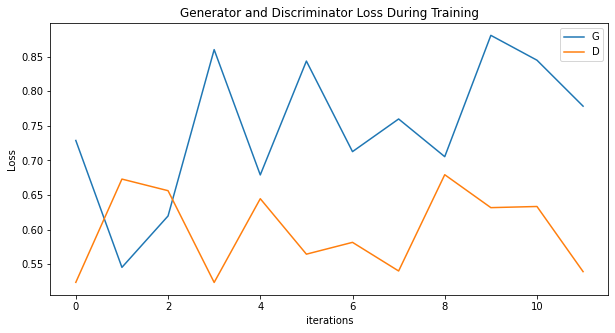

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

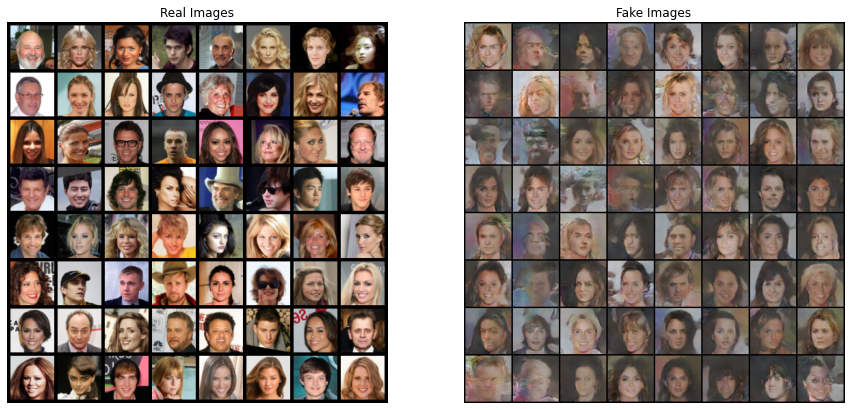

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(visionUtils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()